# 2023年 世界モデル 第7回演習

本演習では，いわゆる世界モデルを用いた強化学習アルゴリズムである **RSSM (Recurrent State Space Model)**[[1]](#scrollTo=J_PCEOJ69prx) と**Dreamer**[[2]](#scrollTo=J_PCEOJ69prx)を実装します．

## 目次

1. [準備](#scrollTo=yDN8Ohc0Mh8C)
2. [環境の設定](#scrollTo=_eayBK1HPV5H)
3. [RSSM](#scrollTo=B3rWEGtkA3e_&line=1&uniqifier=1)
4. [RSSMの実装](#scrollTo=xJfU7ygCMeJn)
5. [補助機能の実装](#scrollTo=WhlVvU3aZ5FC)
6. [Dreamerの実装](#scrollTo=keAW0J-qS24Q)
7. [エージェントの実装](#scrollTo=GdKZ1S2_boOd)
8. [ハイパーパラメータの設定と学習の準備](#scrollTo=QUPWAkpyc9Z-)
9. [学習](#scrollTo=yUoI0l9Ee0Tp)
10. [結果の確認](#scrollTo=E3F2tAU0kepm)
11. [参考文献](##scrollTo=J_PCEOJ69prx&line=4&uniqifier=1)

## 1.準備
まず，演習を行うために必要な準備を行います．

この演習では，環境として[PyBullet](https://github.com/bulletphysics/bullet3)を用います．PyBulletは`pip`を用いてインストールします．

In [4]:
!pip install setuptools==65.5.0 "wheel<0.40.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.41.3
    Uninstalling wheel-0.41.3:
      Successfully uninstalled wheel-0.41.3
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cvxpy 1.3.2 requires setuptools>65.5.1, but you have setuptools 65.5.0 which is incompatible.


In [5]:
!pip install pybullet gym==0.21.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 35.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616797 sha256=7e7fa5a270cef696c31c3a8ee4aa1b5414096da0a016a2b12ec30a17cb9207cb
  Stored in directory: /root/.cache/pip/wheels/81/aa/90/b67df76370d3916a2189b662cf48da38ce41a4e7e58b6abff5
  Created wheel for pybullet: filename=pybullet-3.2.5-cp310-cp310-linux_x86_64.whl size=99850562 sha256=d0b2ee95f2f1218b00ba33b689d4f9d724b4e88d506e74b72a26f12955f74e7b
  Stored in directory: /root/.cache/pip/wheels/6b/fa/1a/c315a5133f0c9bf202a6daa5d70891120e7fe403e06e3407cc
Successfully built gym pybullet
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


必要なライブラリをインポートします．今回使うライブラリは，PyBullet以外はColabでは最初から入っていますが，手元の環境で行う場合はこれらのライブラリも`pip`等で事前にインストールする必要があります．

In [6]:
import gc
import os
import time
from typing import Any, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.tensorboard import SummaryWriter

# 可視化のためにTensorBoardを用いるので，Colab上でTensorBoardを表示するための宣言を行う
%load_ext tensorboard

In [7]:
import pybullet_envs  # PyBulletの環境をgymに登録する

今回の学習にはGPUが必要です．

以下のコードを実行して， 結果が'cuda'でなければ「ランタイム」 →　 「ランタイムのタイプを変更」でGPUモードに変更しましょう．

In [8]:
# torch.deviceを定義．この変数は後々モデルやデータをGPUに転送する時にも使います
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


きちんとGPUが使える状態になっているかチェックしておきます． ColabのGPU割り当てにはランダム性があるので人によって結果が違う場合がありますが， どれでも実行には問題ありません（学習にかかる時間に幾らかの差は出ます）．

In [9]:
!nvidia-smi

Thu Nov 23 15:28:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2.環境の設定

環境を扱いやすくするために，いくつかラッパーを挟みます．

今回はPyBulletを画像入力の環境として用います．環境を作成して，画像がどのようになっているかを見てみましょう．

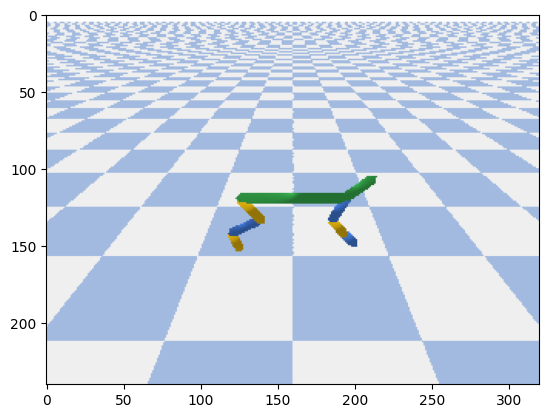

In [10]:
env = gym.make("HalfCheetahBulletEnv-v0")  # 環境を読み込む．
env.reset()
image = env.render(mode="rgb_array")  # env.renderで画像を取得
plt.imshow(image)
plt.show()
env.close()

画像が無事表示されたでしょうか．

中央に見える２本足の何かを前方に走らせるのが`HalfCheetah`のタスクです．

上記画像ではカメラの位置が遠いので，カメラの位置と角度を調整するラッパーを作成します．

また，同時に通常は低次元の状態を観測として用いる環境である`HalfCheetahBulletEnv-v0`を画像を観測として用いる環境として扱えるようにしておきます

In [11]:
class GymWrapper_PyBullet(object):
    """
    PyBullet環境のためのラッパー
    """

    metadata = {"render.modes": ["human", "rgb_array"]}
    reward_range = (-np.inf, np.inf)

    # __init__でカメラ位置に関するパラメータ（ cam_dist:カメラ距離，cam_yaw：カメラの水平面での回転，cam_pitch:カメラの縦方向での回転）を受け取り，カメラの位置を調整できるようにします.
    # 　同時に画像の大きさも変更できるようにします
    def __init__(
        self,
        env: gym.Env,
        cam_dist: int = 3,
        cam_yaw: int = 0,
        cam_pitch: int = -30,
        render_width: int = 320,
        render_height: int = 240,
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        env : gym.Env
            gymで提供されている環境のインスタンス．
        cam_dist : int
            カメラの距離．
        cam_yaw : int
            カメラの水平面での回転．
        cam_pitch : int
            カメラの縦方向での回転．
        render_width : int
            観測画像の幅．
        render_height : int
            観測画像の高さ．
        """
        self._env = env
        self._env.env._cam_dist = cam_dist
        self._env.env._cam_yaw = cam_yaw
        self._env.env._cam_pitch = cam_pitch
        self._env.env._render_width = render_width
        self._env.env._render_height = render_height

    def __getattr(self, name: str) -> Any:
        """
        環境が保持している属性値を取得するメソッド．

        Parameters
        ----------
        name : str
            取得したい属性値の名前．

        Returns
        -------
        _env.name : Any
            環境が保持している属性値．
        """
        return getattr(self._env, name)

    @property
    def observation_space(self) -> gym.spaces.Box:
        """
        観測空間に関する情報を取得するメソッド．

        Returns
        -------
        space : gym.spaces.Box
            観測空間に関する情報（各画素値の最小値，各画素値の最大値，観測データの形状， データの型）．
        """
        width = self._env.env._render_width
        height = self._env.env._render_height
        return gym.spaces.Box(0, 255, (height, width, 3), dtype=np.uint8)

    @property
    def action_space(self) -> gym.spaces.Box:
        """
        行動空間に関する情報を取得するメソッド．

        Returns
        -------
        space : gym.spaces.Box
            行動空間に関する情報（各行動の最小値，各行動の最大値，行動空間の次元， データの型） ．
        """
        return self._env.action_space

    # 　元の観測（低次元の状態）は今回は捨てて，env.render()で取得した画像を観測とします.
    #  画像，報酬，終了シグナルが得られます.
    def step(self, action: np.ndarray) -> (np.ndarray, float, bool, dict):
        """
        環境に行動を与え次の観測，報酬，終了フラグを取得するメソッド．

        Parameters
        ----------
        action : np.dnarray (action_dim, )
            与える行動．

        Returns
        -------
        obs : np.ndarray (height, width, 3)
            行動を与えたときの次の観測．
        reward : float
            行動を与えたときに得られる報酬．
        done : bool
            エピソードが終了したかどうか表すフラグ．
        info : dict
            その他の環境に関する情報．
        """
        _, reward, done, info = self._env.step(action)
        obs = self._env.render(mode="rgb_array")
        return obs, reward, done, info

    def reset(self) -> np.ndarray:
        """
        環境をリセットするためのメソッド．

        Returns
        -------
        obs : np.ndarray (height, width, 3)
            環境をリセットしたときの初期の観測．
        """
        self._env.reset()
        obs = self._env.render(mode="rgb_array")
        return obs

    def render(self, mode="human", **kwargs) -> np.ndarray:
        """
        観測をレンダリングするためのメソッド．

        Parameters
        ----------
        mode : str
            レンダリング方法に関するオプション． (default='human')

        Returns
        -------
        obs : np.ndarray (height, width, 3)
            観測をレンダリングした結果．
        """
        return self._env.render(mode, **kwargs)

    def close(self) -> None:
        """
        環境を閉じるためのメソッド．
        """
        self._env.close()

環境にラッパーを適用します．同時にカメラ位置に関するパラメータを与えて，カメラの位置と角度を調整します．（今回カメラのパラメータは人力で決めています．環境が変わると調整し直す必要があるかもしれません）．また，画像の大きさも同時に64x64に変更しています．

In [12]:
env = gym.make("HalfCheetahBulletEnv-v0")
# カメラのパラメータを与えてカメラの位置と角度，画像の大きさを調整
env = GymWrapper_PyBullet(
    env, cam_dist=2, cam_pitch=0, render_width=64, render_height=64
)

もう一度画像を確認してみましょう．

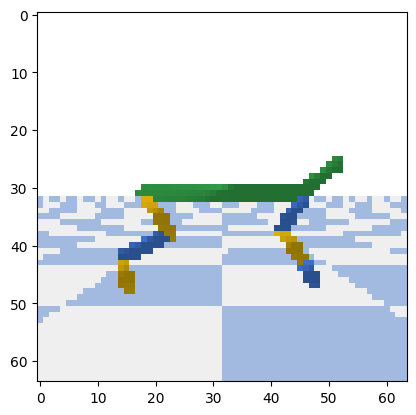

In [13]:
env.reset()
image = env.render(mode="rgb_array")
plt.imshow(image)
plt.show()
env.close()

カメラの位置が変わりました．これで元の観測より学習データとして扱いやすくなったと思います．

また，より環境を扱いやすくするために，同じ行動を何度か繰り返すラッパーを挟みます．

In [14]:
class RepeatAction(gym.Wrapper):
    """
    同じ行動を指定された回数自動的に繰り返すラッパー．観測は最後の行動に対応するものになる
    """

    def __init__(self, env: GymWrapper_PyBullet, skip: int = 4) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        env : GymWrapper_PyBullet
            環境のインスタンス．今回は先程定義したラッパーでラップした環境を利用する．
        skip : int
            同じ行動を繰り返す回数．
        """
        gym.Wrapper.__init__(self, env)
        self._skip = skip

    def reset(self) -> np.ndarray:
        """
        環境をリセットするためのメソッド．

        Returns
        -------
        obs : np.ndarray (width, height, 3)
            環境をリセットしたときの初期の観測．
        """
        return self.env.reset()

    def step(self, action: np.ndarray) -> (np.ndarray, float, bool, dict):
        """
        環境に行動を与え次の観測，報酬，終了フラグを取得するメソッド．
        与えられた行動をskipの回数だけ繰り返した結果を返す．

        Parameters
        ----------
        action : np.ndarray (action_dim, )
            与える行動．

        Returns
        -------
        obs : np.ndarray (width, height, 3)
            行動をskipの回数だけ繰り返したあとの観測．
        total_reawrd : float
            行動をskipの回数だけ繰り返したときの報酬和．
        done : bool
            エピソードが終了したかどうか表すフラグ．
        info : dict
            その他の環境に関する情報．
        """
        total_reward = 0.0
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

以上でラッパーに関する話は終わりです．これまでに作成したラッパーをまとめて適用し，最終的に用いる環境を作成する関数を実装して，本題のアルゴリズムの実装に移りましょう．

In [15]:
def make_env() -> RepeatAction:
    """
    作成たラッパーをまとめて適用して環境を作成する関数．

    Returns
    -------
    env : RepeatAction
        ラッパーを適用した環境．
    """
    env = gym.make("HalfCheetahBulletEnv-v0")  # 環境を読み込む．今回はHalfCheetah
    # Dreamerでは観測は64x64のRGB画像
    env = GymWrapper_PyBullet(
        env, cam_dist=2, cam_pitch=0, render_width=64, render_height=64
    )
    env = RepeatAction(env, skip=2)  # DreamerではActionRepeatは2
    return env

## 3.RSSM
RSSMは以下のパーツに分けることができます．

**Deterministic state model:**
> $h_{t}=f(h_{t-1}, s_{t-1}, a_{t-1})$

**Stochastic state model:**
> $s_{t}$ ~ $p(s_{t} | h_{t})$

**Observation model:**
> $o_{t}$ ~ $p(o_{t} | h_{t}, s_{t})$

**Reward model:**
> $r_{t}$~ $p(r_{t} | h_{t}, s_{t})$

[以下の画像](https://towardsai.net/p/machine-learning/dreamer-8b5a42acebbf)は1つの時間ステップでのRSSMの挙動を示しています．

![1stepあたりの模式図](https://cdn-images-1.medium.com/max/1024/1*4b2l7Fr4eavQV5ZMouCT-g.png)



Deterministic state modelで，RNNは，前の時間ステップの行動$a_{t-1}$と事後確率状態$s'_{t-1}$，決定論的状態$h_{t-1}$を入力とし，決定論的状態$h_t$を出力します．

$h_{t}$は (1)事前状態確率$s_{t}$を計算するために，1つの隠れ層を持つMLPに供給され （本実装では線形変換），(2)事後確率状態$s'_{t}$を計算するために，画像埋め込み$e_t$（本実装では`embedded_obs`と表現される）と連結され，別の単層MLP（線形変換）に供給されます．

その後，$h_{t}$と$s'_{t}$を連結したものを用いて，画像や報酬などを再構成します．








## 4.RSSMの実装


上記をもとにRSSMの実装を行います．実装では，以下の3つのクラスに分けて実装します．

* 状態遷移を担うクラス(TransitionModel)
* 観測を復元するデコーダクラス(ObservationMode)
* 報酬を予測するクラス(RewardModel)

※TransitionModelは上記Deterministic state model, Stochastic state modelを合体させています．


まず実装するのがTransitionModelです．

1ステップ先の未来の状態表現を予測する機能を担います．

学習の方針として，状態遷移を用いた1ステップ先の未来の状態表現の分布である"prior"と，1ステップ先の観測の情報を取り込んで計算した状態表現の分布である"posterior"が一致するように学習します．

"posterior"は後に観測の再構成誤差と報酬の予測誤差によって学習されるので，"posterior"は上記の2つの誤差によって妥当な状態表現になるように学習され，同時に"prior"をそれに近づけることで，状態表現の空間で未来の予測が可能になるように学習する，というイメージです．よって，これを踏まえたクラスの実装になっています．

状態表現として，決定的な状態である"rnn_hidden"と，確率的な状態である"state"の両方を持っています．

In [16]:
class TransitionModel(nn.Module):
    """
    状態遷移を担うクラス．このクラスは複数の要素を含んでいます．
    決定的状態遷移 （RNN) : h_t+1 = f(h_t, s_t, a_t)
    確率的状態遷移による1ステップ予測として定義される "prior" : p(s_t+1 | h_t+1)
    観測の情報を取り込んで定義される "posterior": q(s_t+1 | h_t+1, e_t+1)
    """

    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        rnn_hidden_dim: int,
        hidden_dim: int = 200,
        min_stddev: float = 0.1,
        act: "function" = F.elu,
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        state_dim : int
            確率的状態sの次元数．
        action_dim : int
            行動空間の次元数．
        rnn_hidden_dim : int
            決定的状態hの次元数．
        hidden_dim : int
            線形層(fc_state_action, fc_rnn_hidden, fc_rnn_hidden_embedded_obs)の
            出力の次元数．
        min_stddev : float
            確率状態遷移の標準偏差の最小値．
        act : function
            活性化関数．
        """
        super(TransitionModel, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.rnn_hidden_dim = rnn_hidden_dim
        self.fc_state_action = nn.Linear(state_dim + action_dim, hidden_dim)

        self.fc_rnn_hidden = nn.Linear(rnn_hidden_dim, hidden_dim)
        self.fc_state_mean_prior = nn.Linear(hidden_dim, state_dim)
        self.fc_state_stddev_prior = nn.Linear(hidden_dim, state_dim)
        self.fc_rnn_hidden_embedded_obs = nn.Linear(rnn_hidden_dim + 1024, hidden_dim)
        self.fc_state_mean_posterior = nn.Linear(hidden_dim, state_dim)
        self.fc_state_stddev_posterior = nn.Linear(hidden_dim, state_dim)

        # next hidden stateを計算
        self.rnn = nn.GRUCell(hidden_dim, rnn_hidden_dim)
        self._min_stddev = min_stddev
        self.act = act

    def forward(
        self,
        state: torch.Tensor,
        action: torch.Tensor,
        rnn_hidden: torch.Tensor,
        embedded_next_obs: torch.Tensor,
    ) -> Tuple[torch.Tensor]:
        """
        prior p(s_t+1 | h_t+1) と posterior q(s_t+1 | h_t+1, e_t+1) を返すメソッド．
        この2つが近づくように学習する．

        Parameters
        ----------
        state : torch.Tensor (batch size, state dim)
            時刻tの状態(s_t)．
        action : torch.Tensor (batch size, action dim)
            時刻tの行動(a_t)．
        rnn_hidden : torch.Tensor (batch size, rnn hidden dim)
            RNNが保持している決定的状態(h_t)．
        embedded_next_obs : torch.Tensor (batch size, 1024)
            時刻t+1の観測をエンコードしたもの(e_t+1)．

        Returns
        -------
        next_state_prior : torch.Tensor (batch size, state dim)
            prior(p(s_t+1 | h_t+1))による次の時刻の状態の予測．
        next_state_posterior : torch.Tensor (batch size, state dim)
            posterior(q(s_t+1 | h_t+1, e_t+1))による次の時刻の状態の予測．
        rnn_hidden : torch.Tensor (batch size, rnn hidden dim)
            RNNが保持する次の決定的状態(h_t+1)．
        """
        next_state_prior, rnn_hidden = self.prior(
            self.recurrent(state, action, rnn_hidden)
        )
        next_state_posterior = self.posterior(rnn_hidden, embedded_next_obs)
        return next_state_prior, next_state_posterior, rnn_hidden

    def recurrent(
        self, state: torch.Tensor, action: torch.Tensor, rnn_hidden: torch.Tensor
    ) -> torch.Tensor:
        """
        決定的状態 h_t+1 = f(h_t, s_t, a_t)を計算するメソッド．

        Parameters
        ----------
        state : torch.Tensor (batch size, state dim)
            時刻tの状態(s_t)．
        action : torch.Tensor (batch size, action dim)
            時刻tの行動(a_t)．
        rnn_hidden : torch.Tensor (batch size, rnn hidden dim)
            RNNが保持している決定的状態(h_t)．

        Returns
        -------
        rnn_hidden : torch.Tensor (batch size, rnn hidden dim)
            RNNが保持する次の決定的状態(h_t+1)．
        """
        hidden = self.act(self.fc_state_action(torch.cat([state, action], dim=1)))
        # h_t+1を求める
        rnn_hidden = self.rnn(hidden, rnn_hidden)
        return rnn_hidden

    def prior(self, rnn_hidden: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        prior p(s_t+1 | h_t+1) を計算するメソッド．

        Parameters
        ----------
        rnn_hidden : torch.Tensor (batch size, rnn hidden dim)
            RNNが保持している決定的状態(h_t+1)．

        Returns
        -------
        state : torch.Tensor (batch size, state dim)
            決定的状態を用いてサンプリングされた確率的な状態(s_t+1)．
            ここでは決定的状態h_t+1からガウス分布の平均，標準偏差を推定してサンプリングしています．
        rnn_hidden : torch.Tensor (batch size, rnn hidden dim)
            RNNが保持する決定的状態(h_t+1)．
            入力からのものをそのまま返しています．
        """
        #h_t+1を求める（ヒント: self.act, self.fc_rnn_hiddenを使用）
        hidden = self.act(self.fc_rnn_hidden(rnn_hidden))  # WRITE ME

        mean = self.fc_state_mean_prior(hidden)
        stddev = F.softplus(self.fc_state_stddev_prior(hidden)) + self._min_stddev
        return Normal(mean, stddev), rnn_hidden

    def posterior(
        self, rnn_hidden: torch.Tensor, embedded_obs: torch.Tensor
    ) -> torch.Tensor:
        """
        posterior q(s_t+1 | h_t+1, e_t+1)  を計算するメソッド．

        Parameters
        ----------
        rnn_hidden : torch.Tensor (batch size, rnn hidden dim)
            RNNが保持している決定的状態(h_t+1)．
        embedded_obs : torch.Tensor (batch size, 1024)
            時刻t+1の観測をエンコードしたもの．

        Returns
        -------
        state : torch.Tensor (batch size, state dim)
            決定的状態とエンコードした観測を用いてサンプリングされた確率的な状態(s_t+1)．
            ここでは決定的状態h_t+1とエンコードした観測e_t+1からガウス分布の平均，標準偏差を推定してサンプリングしています．
        """
        # h_t+1，o_t+1を結合し，q(s_t+1 | h_t+1, e_t+1) を計算する
        hidden = self.fc_rnn_hidden_embedded_obs(torch.cat([rnn_hidden, embedded_obs], dim=1)) # WRITE ME
        mean = self.fc_state_mean_posterior(hidden)
        stddev = F.softplus(self.fc_state_stddev_posterior(hidden)) + self._min_stddev
        return Normal(mean, stddev)

次に，観測を再構成するデコーダを実装します．

In [17]:
class ObservationModel(nn.Module):
    """
    p(o_t | s_t, h_t)
    低次元の状態表現から画像を再構成するデコーダ (3, 64, 64)
    """

    def __init__(self, state_dim: int, rnn_hidden_dim: int) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        state_dim : int
            確率的状態sの次元数．
        rnn_hidden_dim : int
            決定的状態hの次元数．
        """
        super(ObservationModel, self).__init__()
        self.fc = nn.Linear(state_dim + rnn_hidden_dim, 1024)
        self.dc1 = nn.ConvTranspose2d(1024, 128, kernel_size=5, stride=2)
        self.dc2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2)
        self.dc3 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2)
        self.dc4 = nn.ConvTranspose2d(32, 3, kernel_size=6, stride=2)

    def forward(self, state: torch.Tensor, rnn_hidden: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行うメソッド．確率的状態sと決定的状態hから観測を再構成する．

        Parameters
        ----------
        state : torch.Tensor (batch size, state dim)
            確率的状態s．
        rnn_hidden : torch.Tensor (batch size, rnn_hidden_dim)
            決定的状態h．

        Returns
        -------
        obs : torch.Tensor (batch size, 3, 64, 64)
            再構成された観測o．
        """
        hidden = self.fc(torch.cat([state, rnn_hidden], dim=1))
        hidden = hidden.view(hidden.size(0), 1024, 1, 1)
        hidden = F.relu(self.dc1(hidden))
        hidden = F.relu(self.dc2(hidden))
        hidden = F.relu(self.dc3(hidden))
        obs = self.dc4(hidden)
        return obs

次に，報酬を予測するRewardモデルを実装します．

In [18]:
class RewardModel(nn.Module):
    """
    p(r_t | s_t, h_t)
    低次元の状態表現から報酬を予測する．
    """

    def __init__(
        self,
        state_dim: int,
        rnn_hidden_dim: int,
        hidden_dim: int = 400,
        act: "function" = F.elu,
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        state_dim : int
            確率的状態sの次元数．
        rnn_hidden_dim : int
            決定的状態hの次元数．
        hidden_dim : int
            報酬モデルの隠れ層の次元数． (default=400)
        act : function
            報酬モデルに利用される活性化関数． (default=torch.nn.functional.elu)
        """
        super(RewardModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.act = act

    def forward(self, state: torch.Tensor, rnn_hidden: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行うメソッド．確率的状態sと決定的状態hから報酬rを推定する．

        Parameters
        ----------
        state : torch.Tensor (batch size, state dim)
            確率的状態s．
        rnn_hidden : torch.Tensor (batch size, rnn_hidden_dim)
            決定的状態h．

        Returns
        -------
        reward : torch.Tensor (batch size, 1)
            確率的状態s，決定的状態hに対する報酬r．
        """
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        reward = self.fc4(hidden)
        return reward

最後に，上記で定義された３つのモデルを`RSSM`クラスとしてまとめます.




In [19]:
class RSSM:
    """
    TransitionModel, ObservationModel, RewardModelの3つをまとめたRSSMクラス．
    """

    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        rnn_hidden_dim: int,
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        state_dim : int
            確率的状態sの次元数．
        action_dim : int
            行動空間の次元数．
        rnn_hidden_dim : int
            決定的状態hの次元数．
        """
        self.transition = TransitionModel(state_dim, action_dim, rnn_hidden_dim).to(
            device
        )
        self.observation = ObservationModel(
            state_dim,
            rnn_hidden_dim,
        ).to(device)
        self.reward = RewardModel(
            state_dim,
            rnn_hidden_dim,
        ).to(device)

## 5.補助機能の実装

モデルの実装の前に，いくつか学習上必要になる補助機能を実装しておきましょう．具体的にはリプレイバッファ，観測の前処理を行う関数，λ-returnを計算する関数 の3つです．

まずはリプレイバッファを実装します．ただし，RNNを使う関係上一連の系列として経験をサンプルしてくる必要があるため，DQNの時よりは少し実装に工夫が必要です．

In [20]:
# こちらはDQNのReplayBufferの定義
class ReplayBuffer:
    """
    これまでの経験をためておくリプレイバッファ．
    """

    def __init__(self, memory_size: int) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        memory_size : int
            リプレイバッファに貯められるデータの上限．
        """
        self.memory_size = memory_size
        # 収集する経験は上限を決め古いものから削除する．
        self.memory = deque([], maxlen=memory_size)

    def append(self, transition: dict) -> None:
        """
        環境から得た経験（状態，行動，次の状態，報酬，終了フラグ）をキューに追加するメソッド．
        dequeを用いているため上限(memory_size)に達すると古いものが削除される．

        Parameters
        ----------
        trainsition : dict
            状態(state)，次の状態(next_state)，報酬(reward)，行動(action)，終了フラグ(done)を格納した辞書．
        """
        self.memory.append(transition)

    def sample(self, batch_size: int) -> dict:  # 貯めた経験の中からランダムにミニバッチ単位で経験を取り出す．
        """
        バッファに貯めた経験の中からランダムにミニバッチ単位で経験を取り出すメソッド．

        Parameters
        ----------
        batch_size : int
            バッチサイズ．

        Returns
        -------
        sample : dict
            状態(states)，次の状態(next_states)，報酬(rewards)，行動(actions)，終了フラグ(dones)をバッチサイズ分だけ格納した辞書．
        """
        batch_indexes = np.random.randint(0, len(self.memory), size=batch_size)
        states = np.array([self.memory[index]["state"] for index in batch_indexes])
        next_states = np.array(
            [self.memory[index]["next_state"] for index in batch_indexes]
        )
        rewards = np.array([self.memory[index]["reward"] for index in batch_indexes])
        actions = np.array([self.memory[index]["action"] for index in batch_indexes])
        dones = np.array([self.memory[index]["done"] for index in batch_indexes])
        return {
            "states": states,
            "next_states": next_states,
            "rewards": rewards,
            "actions": actions,
            "dones": dones,
        }

In [21]:
# 　今回のReplayBuffer
class ReplayBuffer(object):
    """
    RNNを用いて訓練するのに適したリプレイバッファ．
    """

    def __init__(
        self, capacity: int, observation_shape: List[int], action_dim: int
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        capacity : int
            リプレイバッファにためておくことができる経験の上限．
        observation_shape : List[int]
            環境から与えられる観測の形状．
        action_dim : int
            行動空間の次元数．
        """
        self.capacity = capacity

        self.observations = np.zeros((capacity, *observation_shape), dtype=np.uint8)
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
        self.rewards = np.zeros((capacity, 1), dtype=np.float32)
        self.done = np.zeros((capacity, 1), dtype=bool)
        # self.done = np.zeros((capacity, 1), dtype=np.bool)

        self.index = 0
        self.is_filled = False

    def push(
        self, observation: np.ndarray, action: np.ndarray, reward: float, done: bool
    ) -> None:
        """
        リプレイバッファに経験を追加するメソッド．

        Parameters
        ----------
        observation : np.ndarray (64, 64, 3)
            環境から得られた観測．
        action : np.ndarray (action_dim, )
            エージェントがとった（もしくは経験を貯める際のランダムな）行動．
        reward : float
            観測に対して行動をとったときに得られる報酬．
        done : bool
            エピソードが終了するかどうかのフラグ．
        """
        self.observations[self.index] = observation
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.done[self.index] = done

        # indexは巡回し，最も古い経験を上書きする
        if self.index == self.capacity - 1:
            self.is_filled = True
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size: int, chunk_length: int) -> Tuple[np.ndarray]:
        """
        経験をリプレイバッファからサンプルします．（ほぼ）一様なサンプルです．
        結果として返ってくるのは観測（画像），行動，報酬，終了シグナルについての(batch_size, chunk_length, 各要素の次元)の配列です．
        各バッチは連続した経験になっています．
        注意: chunk_lengthをあまり大きな値にすると問題が発生する場合があります．

        Parameters
        ----------
        batch_size : int
            バッチサイズ．
        chunk_length : int
            バッチあたりの系列長．


        Returns
        -------
        sampled_observations : np.ndarray (batch size, chunk length, 3, 64, 64)
            バッファからサンプリングされた観測．
        sampled_actions : np.ndarray (batch size, chunk length, action dim)
            バッファからサンプリングされた行動．
        sampled_rewards : np.ndarray (batch size, chunk length, 1)
            バッファからサンプリングされた報酬．
        sampled_rewards : np.ndarray (batch size, chunk length, 1)
            バッファからサンプリングされたエピソードの終了フラグ．
        """
        episode_borders = np.where(self.done)[0]
        sampled_indexes = []
        for _ in range(batch_size):
            cross_border = True
            while cross_border:
                initial_index = np.random.randint(len(self) - chunk_length + 1)
                final_index = initial_index + chunk_length - 1
                cross_border = np.logical_and(
                    initial_index <= episode_borders, episode_borders < final_index
                ).any()  # 論理積
            sampled_indexes += list(range(initial_index, final_index + 1))

        sampled_observations = self.observations[sampled_indexes].reshape(
            batch_size, chunk_length, *self.observations.shape[1:]
        )
        sampled_actions = self.actions[sampled_indexes].reshape(
            batch_size, chunk_length, self.actions.shape[1]
        )
        sampled_rewards = self.rewards[sampled_indexes].reshape(
            batch_size, chunk_length, 1
        )
        sampled_done = self.done[sampled_indexes].reshape(batch_size, chunk_length, 1)
        return sampled_observations, sampled_actions, sampled_rewards, sampled_done

    def __len__(self) -> int:
        """
        バッファに貯められている経験の数を返すメソッド．

        Returns
        -------
        length : int
            バッファに貯められている経験の数．
        """
        return self.capacity if self.is_filled else self.index

次に観測の前処理を行う関数を実装します．ちなみに，これもラッパーとして最初から適用してしまわないのは，リプレイバッファにはより容量の小さなnp．uint8の形式で保存しておきたいためです．

In [22]:
def preprocess_obs(obs: np.ndarray) -> np.ndarray:
    """
    画像を正規化する．[0, 255] -> [-0.5, 0.5]．

    Parameters
    ----------
    obs : np.ndarray (64, 64, 3) or (chank length, batch size, 3, 64, 64)
        環境から得られた観測．画素値は[0, 255]．

    Returns
    -------
    normalized_obs : np.ndarray (64, 64, 3) or (chank length, batch size, 64, 64, 3)
        画素値を[-0.5, 0.5]で正規化した観測．
    """
    obs = obs.astype(np.float32)
    normalized_obs = obs / 255.0 - 0.5
    return normalized_obs

Dreamerでは価値関数の学習を行いますが，このために通常のTD誤差ではなく，**TD(λ)をベースにしたλ-return**としてターゲット価値を計算し，それと現在の予測価値の誤差を用います．そのためにλ-returnを計算する関数をここで実装しておきます．

In [23]:
def lambda_target(
    rewards: torch.Tensor, values: torch.Tensor, gamma: float, lambda_: float
) -> torch.Tensor:
    """
    価値関数の学習のためのλ-returnを計算する関数．

    Parameters
    ----------
    rewards : torch.Tensor (imagination_horizon+1,  batch size * (chank length - 1))
        報酬モデルによる報酬の推定値．
    values : torch.Tensor (imagination_horizon+1,  batch size * (chank length - 1))
        価値関数を近似するValueモデルによる状態価値関数の推定値．
    gamma : float
        割引率．
    lambda_ : float
        λ-returnのパラメータλ．

    Returns
    -------
    V_lambda : torch.Tensor (imagination_horizon+1, batch size * (chank length - 1))
        各状態に対するλ-returnの値．
    """
    V_lambda = torch.zeros_like(rewards, device=rewards.device)

    H = rewards.shape[0] - 1
    V_n = torch.zeros_like(rewards, device=rewards.device)
    V_n[H] = values[H]
    for n in range(1, H + 1):
        # まずn-step returnを計算します
        # 注意: 系列が途中で終わってしまったら，可能な中で最大のnを用いたn-stepを使います
        V_n[:-n] = (gamma**n) * values[n:]
        for k in range(1, n + 1):
            if k == n:
                V_n[:-n] += (gamma ** (n - 1)) * rewards[k:]
            else:
                V_n[:-n] += (gamma ** (k - 1)) * rewards[k : -n + k]

        # lambda_でn-step returnを重みづけてλ-returnを計算します
        if n == H:
            V_lambda += (lambda_ ** (H - 1)) * V_n
        else:
            V_lambda += (1 - lambda_) * (lambda_ ** (n - 1)) * V_n

    return V_lambda

## 6.Dreamerの実装

続いてDreamerの実装です．Dreamerの実装では以下の3クラスは上で定義したRSSMの各クラスと同義ですので，
改めて定義はしておらず`RSSM`クラスを呼び出して使用することとします．
* 状態遷移を担うクラス(TransitionModel)
* 観測を復元するデコーダクラス(ObservationModel)
* 報酬を予測するクラス(RewardModel)


そのため，新たに定義するモデルは，以下の３つのみになります．
* 観測の画像をベクトルに変換するエンコーダクラス(Encoder)
* 価値関数を計算するクラス(ValueModel)
* 実際に行動を決定するクラス(ActionModel)


まずエンコーダを実装します．ここでは，CNN(Convolutional Neural Network)を用いて，観測の画像をベクトルに変換します．

In [24]:
class Encoder(nn.Module):
    """
    (3, 64, 64)の画像を(1024,)のベクトルに変換するエンコーダクラス．
    """

    def __init__(self) -> None:
        """
        コンストラクタ．
        層の定義のみを行う．
        """
        super(Encoder, self).__init__()
        self.cv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2)
        self.cv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.cv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.cv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2)

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行うメソッド．観測画像をベクトルに埋め込む．

        Parameters
        ----------
        obs : torch.Tensor (64, 64, 3)
            環境から得られた観測画像．

        Returns
        -------
        embedded_obs : torch.Tensor (batch size, 1024)
            観測を1024次元のベクトルに埋め込んだもの．
        """
        hidden = F.relu(self.cv1(obs))
        hidden = F.relu(self.cv2(hidden))
        hidden = F.relu(self.cv3(hidden))
        embedded_obs = F.relu(self.cv4(hidden)).reshape(hidden.size(0), -1)
        return embedded_obs

ここからがDreamerの中核となる部分で，RSSMの学習を通して獲得された低次元の状態表現の上でActor-Criticを行います.


以下で，価値関数を近似するValueモデル $v_{\phi}(s_{\tau})　\approx E_{q(.|s_{\tau})}(\sum_{\tau=t}^{t+H}(\gamma^{\tau-t}r_{\tau}) )$ を実装します．Q学習などで用いられる状態行動価値関数Q(s, a)ではなく，状態価値関数V(s)であることに多少の注意が必要です．

In [25]:
class ValueModel(nn.Module):
    """
    低次元の状態表現(state_dim + rnn_hidden_dim)から状態価値を出力するクラス．
    """

    def __init__(
        self,
        state_dim: int,
        rnn_hidden_dim: int,
        hidden_dim: int = 400,
        act: "function" = F.elu,
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        state_dim : int
            確率的状態sの次元数．
        rnn_hidden_dim : int
            決定的状態hの次元数．
        hidden_dim : int
            モデルの隠れ層の次元数． (default=400)
        act : function
            モデルの活性化関数． (default=torch.nn.functional.elu)
        """
        super(ValueModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.act = act

    def forward(self, state: torch.Tensor, rnn_hidden: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行うメソッド．低次元の状態表現から状態価値を推定する．

        Parameters
        ----------
        state : torch.Tensor (batch size, state dim)
            確率的状態s．
        rnn_hidden : torch.Tensor (batch size, rnn_hidden_dim)
            決定的状態h．

        Returns
        -------
        state_value : torch.Tensor (batch size, 1)
            入力された状態に対する状態価値の推定値．
        """
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        state_value = self.fc4(hidden)
        return state_value

最後です．実際に行動を出力するActionモデル $a_{\tau} \sim q_{\delta}(a_{\tau}|s_{\tau})$ を実装します．

Actionモデルは価値の見積もりを最大化することを目的とします．



In [26]:
class ActionModel(nn.Module):
    """
    低次元の状態表現(state_dim + rnn_hidden_dim)から行動を計算するクラス．
    """

    def __init__(
        self,
        state_dim: int,
        rnn_hidden_dim: int,
        action_dim: int,
        hidden_dim: int = 400,
        act: "function" = F.elu,
        min_stddev: float = 1e-4,
        init_stddev: float = 5.0,
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        state_dim : int
            確率的状態sの次元数．
        rnn_hidden_dim : int
            決定的状態hの次元数．
        action_dim : int
            行動空間の次元数．
        hidden_dim : int
            モデルの隠れ層の次元数． (default=400)
        act : function
            モデルの活性化関数． (default=torch.nn.functional.elu)
        min_stddev : float
            行動をサンプリングする分布の標準偏差の最小値． (default=1e-4)
        init_stddev : float
            行動をサンプリングする分布の標準偏差の初期値． (default=5.0)
        """
        super(ActionModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, action_dim)
        self.fc_stddev = nn.Linear(hidden_dim, action_dim)
        self.act = act
        self.min_stddev = min_stddev
        self.init_stddev = np.log(np.exp(init_stddev) - 1)

    def forward(
        self, state: torch.Tensor, rnn_hidden: torch.Tensor, training: bool = True
    ) -> None:
        """
        順伝播を行うメソッド．入力された状態に対する行動を出力する．
        training=Trueなら，NNのパラメータに関して微分可能な形の行動のサンプル（Reparametrizationによる）を返す．
        training=Falseなら，行動の確率分布の平均値を返す．

        Parameters
        ----------
        staet : torch.Tensor (batch size, state dim)
            確率的状態s．
        rnn_hidden : torch.Tensor (batch size, rnn_hidden_dim)
            決定的状態h．
        training : bool
            訓練か推論かを示すフラグ． (default=True)

        Returns
        -------
        action : torch.Tensor (batch size, action dim)
            入力された状態に対する行動．
            training=Trueでは微分可能な形の行動をサンプリングした値，
            training=Falseでは行動の確率分布の平均値を返す．
        """
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        hidden = self.act(self.fc4(hidden))

        # Dreamerの実装に合わせて少し平均と分散に対する簡単な変換が入っています
        mean = self.fc_mean(hidden)
        mean = 5.0 * torch.tanh(mean / 5.0)
        stddev = self.fc_stddev(hidden)
        stddev = F.softplus(stddev + self.init_stddev) + self.min_stddev

        if training:
            action = torch.tanh(Normal(mean, stddev).rsample())  # 微分可能にするためrsample()
        else:
            action = torch.tanh(mean)
        return action

実装の詳細まで掴みきれなくとも，個々のクラスが担っている役割が大雑把にでもわかっていただければ幸いです.

## 7.エージェントの実装

Dreamerでは行動を計算するために低次元の状態表現が必要で，この状態表現はRSSMを用いて計算されるため，テスト時もこの状態表現のためにRSSMによる推論を行い続ける必要があります．

そのため，先ほど実装したActionModelをそのまま使っても簡単には行動を決定できません．

ここを扱いやすくするために，RSSMを使って低次元の状態表現を計算しつつ，行動を決定するAgentクラスを実装します．

In [27]:
class Agent:
    """
    ActionModelに基づき行動を決定する．そのためにRSSMを用いて状態表現をリアルタイムで推論して維持するクラス．
    """

    def __init__(self, encoder: Encoder, rssm: RSSM, action_model: ActionModel) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        encoder : Encoder
            上で定義したEncoderクラスのインスタンス．
            観測画像を1024次元のベクトルに埋め込む ．
        rssm : RSSM
            上で定義したRSSMクラスのインスタンス．
            遷移モデル，1024次元のベクトルを観測画像にするデコーダ，報酬を予測するモデルを持つ．
        action_model : ActionModel
            上で定義したActionModelのインスタンス．
            低次元の状態表現から行動を予測する．
        """
        self.encoder = encoder
        self.rssm = rssm
        self.action_model = action_model

        self.device = next(self.action_model.parameters()).device
        self.rnn_hidden = torch.zeros(1, rssm.rnn_hidden_dim, device=self.device)

    def __call__(self, obs: np.ndarray, training=True) -> np.ndarray:
        """
        特殊メソッド．
        インスタンスに直接引数を渡すことで実行される．
        （例）agent = Agent(*args)
             action = agent(obs)  # このときに__call__メソッドが呼び出される．

        Parameters
        ----------
        obs : np.ndarray (batch size, 3, 64, 64)
            環境から得られた観測画像．
        training : bool
            訓練か推論かを示すフラグ． (default=True)

        Returns
        -------
        action : np.ndarray (batch size, action dim)
            入力された観測に対する行動の予測．
        """
        # preprocessを適用，PyTorchのためにChannel-Firstに変換
        obs = preprocess_obs(obs)
        obs = torch.as_tensor(obs, device=self.device)
        obs = obs.transpose(1, 2).transpose(0, 1).unsqueeze(0)

        with torch.no_grad():
            # 観測を低次元の表現に変換し，posteriorからのサンプルをActionModelに入力して行動を決定する
            embedded_obs = self.encoder(obs)
            state_posterior = self.rssm.posterior(self.rnn_hidden, embedded_obs)
            state = state_posterior.sample()
            action = self.action_model(state, self.rnn_hidden, training=training)

            # 次のステップのためにRNNの隠れ状態を更新しておく
            _, self.rnn_hidden = self.rssm.prior(
                self.rssm.recurrent(state, action, self.rnn_hidden)
            )

        return action.squeeze().cpu().numpy()

    def reset(self) -> None:
        """
        RNNの隠れ状態（=決定的状態）をリセットする．
        """
        self.rnn_hidden = torch.zeros(1, self.rssm.rnn_hidden_dim, device=self.device)

## 8.ハイパーパラメータの設定と学習の準備

ここまででDreamerの基本的な構成要素は実装が終わりました．あとはハイパーパラメータを設定し，モデルやリプレイバッファを宣言して学習の準備を整えます．

In [28]:
# リプレイバッファの宣言
buffer_capacity = 200000  # Colabのメモリの都合上，元の実装より小さめにとっています
replay_buffer = ReplayBuffer(
    capacity=buffer_capacity,
    observation_shape=env.observation_space.shape,
    action_dim=env.action_space.shape[0],
)

# モデルの宣言
state_dim = 30  # 確率的状態の次元
rnn_hidden_dim = 200  # 決定的状態（RNNの隠れ状態）の次元
# 確率的状態の次元と決定的状態（RNNの隠れ状態）の次元は一致しなくて良い
encoder = Encoder().to(device)
rssm = RSSM(
    state_dim,
    env.action_space.shape[0],
    rnn_hidden_dim,
)
value_model = ValueModel(state_dim, rnn_hidden_dim).to(device)
action_model = ActionModel(state_dim, rnn_hidden_dim, env.action_space.shape[0]).to(
    device
)

# オプティマイザの宣言
model_lr = 6e-4  # encoder, rssm, obs_model, reward_modelの学習率
value_lr = 8e-5
action_lr = 8e-5
eps = 1e-4
model_params = (
    list(encoder.parameters())
    + list(rssm.transition.parameters())
    + list(rssm.observation.parameters())
    + list(rssm.reward.parameters())
)
model_optimizer = torch.optim.Adam(model_params, lr=model_lr, eps=eps)
value_optimizer = torch.optim.Adam(value_model.parameters(), lr=value_lr, eps=eps)
action_optimizer = torch.optim.Adam(action_model.parameters(), lr=action_lr, eps=eps)

# その他ハイパーパラメータ
seed_episodes = 5  # 最初にランダム行動で探索するエピソード数
all_episodes = 15  # 学習全体のエピソード数（300ほどで，ある程度収束します）
test_interval = 20  # 何エピソードごとに探索ノイズなしのテストを行うか
model_save_interval = 20  # NNの重みを何エピソードごとに保存するか
collect_interval = 100  # 何回のNNの更新ごとに経験を集めるか（＝1エピソード経験を集めるごとに何回更新するか）

action_noise_var = 0.3  # 探索ノイズの強さ

batch_size = 50
chunk_length = 50  # 1回の更新で用いる系列の長さ
imagination_horizon = 15  # Actor-Criticの更新のために，Dreamerで何ステップ先までの想像上の軌道を生成するか


gamma = 0.9  # 割引率
lambda_ = 0.95  # λ-returnのパラメータ
clip_grad_norm = 100  # gradient clippingの値
free_nats = 3  # KL誤差（RSSMのTransitionModelにおけるpriorとposteriorの間の誤差）がこの値以下の場合，無視する

## 9.学習
まず，最初の数エピソードはランダムに行動して経験をリプレイバッファに貯めます．

In [29]:
env = make_env()
for episode in range(seed_episodes):
    obs = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        next_obs, reward, done, _ = env.step(action)
        replay_buffer.push(obs, action, reward, done)
        obs = next_obs

学習結果を確認するために，TensorBoardを立ち上げておきます．

In [30]:
log_dir = "logs"
writer = SummaryWriter(log_dir)
# %tensorboard --logdir='./logs'

以下がメインの学習ループです．それぞれのコメントを見て，実装の内容を追ってください.

学習にはColab Proで3時間半ぐらいの時間がかかります.

In [37]:
for episode in range(seed_episodes, all_episodes):
    # -----------------------------
    #      経験を集める
    # -----------------------------
    start = time.time()
    # 行動を決定するためのエージェントを宣言
    policy = Agent(encoder, rssm.transition, action_model)

    env = make_env()
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = policy(obs)
        # 探索のためにガウス分布に従うノイズを加える(explaration noise)
        action += np.random.normal(0, np.sqrt(action_noise_var),
                                     env.action_space.shape[0])
        next_obs, reward, done, _ = env.step(action)

        #リプレイバッファに観測，行動，報酬，doneを格納
        replay_buffer.push(obs, action, reward, done)

        obs = next_obs
        total_reward += reward

    # 訓練時の報酬と経過時間をログとして表示
    writer.add_scalar('total reward at train', total_reward, episode)
    print('episode [%4d/%4d] is collected. Total reward is %f' %
            (episode+1, all_episodes, total_reward))
    print('elasped time for interaction: %.2fs' % (time.time() - start))

    # NNのパラメータを更新する
    start = time.time()
    for update_step in range(collect_interval):
        # -------------------------------------------------------------------------------------
        #  RSSM(trainsition_model, obs_model, reward_model)の更新 - Dynamics learning
        # -------------------------------------------------------------------------------------
        observations, actions, rewards, _ = \
            replay_buffer.sample(batch_size, chunk_length)

        # 観測を前処理し，RNNを用いたPyTorchでの学習のためにTensorの次元を調整
        observations = preprocess_obs(observations)
        observations = torch.as_tensor(observations, device=device)
        observations = observations.transpose(3, 4).transpose(2, 3)
        observations = observations.transpose(0, 1)
        actions = torch.as_tensor(actions, device=device).transpose(0, 1)
        rewards = torch.as_tensor(rewards, device=device).transpose(0, 1)

        # 観測をエンコーダで低次元のベクトルに変換
        embedded_observations = encoder(
            observations.reshape(-1, 3, 64, 64)).view(chunk_length, batch_size, -1)

        # 低次元の状態表現を保持しておくためのTensorを定義
        states = torch.zeros(chunk_length, batch_size, state_dim, device=device)
        rnn_hiddens = torch.zeros(chunk_length, batch_size, rnn_hidden_dim, device=device)

        # 低次元の状態表現は最初はゼロ初期化（timestep１つ分）
        state = torch.zeros(batch_size, state_dim, device=device)
        rnn_hidden = torch.zeros(batch_size, rnn_hidden_dim, device=device)

        # 状態s_tの予測を行ってそのロスを計算する（priorとposteriorの間のKLダイバージェンス）
        kl_loss = 0
        for l in range(chunk_length-1):
            next_state_prior, next_state_posterior, rnn_hidden = \
                rssm.transition(state, actions[l], rnn_hidden, embedded_observations[l+1])
            state = next_state_posterior.rsample()
            states[l+1] = state
            rnn_hiddens[l+1] = rnn_hidden
            kl = kl_divergence(next_state_prior, next_state_posterior).sum(dim=1) # WRITE ME （ヒント: kl_divergence()を使用）
            kl_loss += kl.clamp(min=free_nats).mean()  # 原論文通り，KL誤差がfree_nats以下の時は無視
        kl_loss /= (chunk_length - 1)

        # states[0] and rnn_hiddens[0]はゼロ初期化なので以降では使わない
        # states，rnn_hiddensは低次元の状態表現
        states = states[1:]
        rnn_hiddens = rnn_hiddens[1:]

        # 観測を再構成，また，報酬を予測
        flatten_states = states.view(-1, state_dim)
        flatten_rnn_hiddens = rnn_hiddens.view(-1, rnn_hidden_dim)
        recon_observations = rssm.observation(flatten_states, flatten_rnn_hiddens).view(chunk_length-1, batch_size, 3, 64, 64)
        predicted_rewards = rssm.reward(flatten_states, flatten_rnn_hiddens).view(chunk_length-1, batch_size, 1)

        # 観測と報酬の予測誤差を計算
        obs_loss = 0.5 * F.mse_loss(recon_observations, observations[1:], reduction='none').mean([0, 1]).sum()
        reward_loss = 0.5 * F.mse_loss(predicted_rewards, rewards[:-1])

        # 以上のロスを合わせて勾配降下で更新する
        model_loss = kl_loss + obs_loss + reward_loss
        model_optimizer.zero_grad()
        model_loss.backward()
        clip_grad_norm_(model_params, clip_grad_norm)
        model_optimizer.step()

        # --------------------------------------------------
        #  Action Model, Value　Modelの更新　- Behavior learning
        # --------------------------------------------------
        # Actor-Criticのロスで他のモデルを更新することはないので勾配の流れを一度遮断
        # flatten_states, flatten_rnn_hiddensは RSSMから得られた低次元の状態表現を平坦化した値
        flatten_states = flatten_states.detach()
        flatten_rnn_hiddens = flatten_rnn_hiddens.detach()

        # DreamerにおけるActor-Criticの更新のために，現在のモデルを用いた
        # 数ステップ先の未来の状態予測を保持するためのTensorを用意
        imagined_states = torch.zeros(imagination_horizon + 1,
                                         *flatten_states.shape,
                                          device=flatten_states.device)
        imagined_rnn_hiddens = torch.zeros(imagination_horizon + 1,
                                                *flatten_rnn_hiddens.shape,
                                                device=flatten_rnn_hiddens.device)

        #　未来予測をして想像上の軌道を作る前に，最初の状態としては先ほどモデルの更新で使っていた
        # リプレイバッファからサンプルされた観測データを取り込んだ上で推論した状態表現を使う
        imagined_states[0] = flatten_states
        imagined_rnn_hiddens[0] = flatten_rnn_hiddens

        # open-loopで未来の状態予測を使い，想像上の軌道を作る
        for h in range(1, imagination_horizon + 1):
            # 行動はActionModelで決定．この行動はモデルのパラメータに対して微分可能で,
            #　これを介してActionModelは更新される
            actions = action_model(flatten_states, flatten_rnn_hiddens)
            flatten_states_prior, flatten_rnn_hiddens = rssm.transition.prior(rssm.transition.recurrent(flatten_states,
                                                                   actions,
                                                                   flatten_rnn_hiddens))
            flatten_states = flatten_states_prior.rsample()
            imagined_states[h] = flatten_states
            imagined_rnn_hiddens[h] = flatten_rnn_hiddens

        # RSSMのreward_modelにより予測された架空の軌道に対する報酬を計算
        flatten_imagined_states = imagined_states.view(-1, state_dim)
        flatten_imagined_rnn_hiddens = imagined_rnn_hiddens.view(-1, rnn_hidden_dim)
        imagined_rewards = \
            rssm.reward(flatten_imagined_states,
                        flatten_imagined_rnn_hiddens).view(imagination_horizon + 1, -1)
        imagined_values = \
            value_model(flatten_imagined_states,
                        flatten_imagined_rnn_hiddens).view(imagination_horizon + 1, -1)

        # λ-returnのターゲットを計算(V_{\lambda}(s_{\tau})
        lambda_target_values = lambda_target(imagined_rewards, imagined_values, gamma, lambda_) # WRITE ME （ヒント: lambda_target()を利用）

        # 価値関数の予測した価値が大きくなるようにActionModelを更新
        # PyTorchの基本は勾配降下だが，今回は大きくしたいので-1をかける
        action_loss = -lambda_target_values.mean()
        action_optimizer.zero_grad()
        action_loss.backward()
        clip_grad_norm_(action_model.parameters(), clip_grad_norm)
        action_optimizer.step()

        # TD(λ)ベースの目的関数で価値関数を更新（価値関数のみを学習するため，学習しない変数のグラフは切っている．)
        imagined_values = value_model(flatten_imagined_states.detach(), flatten_imagined_rnn_hiddens.detach()).view(imagination_horizon + 1, -1)
        value_loss = 0.5 * F.mse_loss(imagined_values, lambda_target_values.detach()) # WRITE ME （ヒント: 0.5 * F.mse_loss()を使用）
        value_optimizer.zero_grad()
        value_loss.backward()
        clip_grad_norm_(value_model.parameters(), clip_grad_norm)
        value_optimizer.step()

        # ログをTensorBoardに出力
        print('update_step: %3d model loss: %.5f, kl_loss: %.5f, '
             'obs_loss: %.5f, reward_loss: %.5f, '
             'value_loss: %.5f action_loss: %.5f'
                % (update_step + 1, model_loss.item(), kl_loss.item(),
                    obs_loss.item(), reward_loss.item(),
                    value_loss.item(), action_loss.item()))
        total_update_step = episode * collect_interval + update_step
        writer.add_scalar('model loss', model_loss.item(), total_update_step)
        writer.add_scalar('kl loss', kl_loss.item(), total_update_step)
        writer.add_scalar('obs loss', obs_loss.item(), total_update_step)
        writer.add_scalar('reward loss', reward_loss.item(), total_update_step)
        writer.add_scalar('value loss', value_loss.item(), total_update_step)
        writer.add_scalar('action loss', action_loss.item(), total_update_step)

    print('elasped time for update: %.2fs' % (time.time() - start))

    # --------------------------------------------------------------
    #    テストフェーズ．探索ノイズなしでの性能を評価する
    # --------------------------------------------------------------
    if (episode + 1) % test_interval == 0:
        policy = Agent(encoder, rssm.transition, action_model)
        start = time.time()
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = policy(obs, training=False)
            obs, reward, done, _ = env.step(action)
            total_reward += reward

        writer.add_scalar('total reward at test', total_reward, episode)
        print('Total test reward at episode [%4d/%4d] is %f' %
                (episode+1, all_episodes, total_reward))
        print('elasped time for test: %.2fs' % (time.time() - start))

    if (episode + 1) % model_save_interval == 0:
        # 定期的に学習済みモデルのパラメータを保存する
        model_log_dir = os.path.join(log_dir, 'episode_%04d' % (episode + 1))
        os.makedirs(model_log_dir)
        torch.save(encoder.state_dict(), os.path.join(model_log_dir, 'encoder.pth'))
        torch.save(rssm.transition.state_dict(), os.path.join(model_log_dir, 'rssm.pth'))
        torch.save(rssm.observation.state_dict(), os.path.join(model_log_dir, 'obs_model.pth'))
        torch.save(rssm.reward.state_dict(), os.path.join(model_log_dir, 'reward_model.pth'))
        torch.save(value_model.state_dict(), os.path.join(model_log_dir, 'value_model.pth'))
        torch.save(action_model.state_dict(), os.path.join(model_log_dir, 'action_model.pth'))
    del env
    gc.collect()

writer.close()

episode [   6/ 100] is collected. Total reward is 1102.253472
elasped time for interaction: 4.61s
update_step:   1 model loss: 89.64141, kl_loss: 44.92152, obs_loss: 40.60925, reward_loss: 4.11063, value_loss: 0.58146 action_loss: -0.17088
update_step:   2 model loss: 64.29022, kl_loss: 19.41825, obs_loss: 40.95669, reward_loss: 3.91529, value_loss: 2.21193 action_loss: -1.00050
update_step:   3 model loss: 62.26352, kl_loss: 15.15821, obs_loss: 43.48325, reward_loss: 3.62207, value_loss: 5.94787 action_loss: -2.15756
update_step:   4 model loss: 60.04533, kl_loss: 13.37572, obs_loss: 43.34203, reward_loss: 3.32759, value_loss: 14.75229 action_loss: -4.15071
update_step:   5 model loss: 52.13242, kl_loss: 11.20197, obs_loss: 38.48616, reward_loss: 2.44429, value_loss: 27.76922 action_loss: -5.60528
update_step:   6 model loss: 46.55433, kl_loss: 10.11299, obs_loss: 34.02815, reward_loss: 2.41319, value_loss: 62.40369 action_loss: -9.55917
update_step:   7 model loss: 44.74579, kl_loss:

KeyboardInterrupt: ignored

TensorBoardで学習結果を確認してみます．

In [ ]:
%tensorboard --logdir='./logs'

##  10.結果の確認
保存された学習済み重みを用いて，動作を確認してみましょう.

学習にはかなりの時間がかかるので，ここでは事前に学習しておいた重みを読み込むことにします．時間のある方は，上記のコードで実際に学習した重みを使って同様に試してみてください.

In [31]:
# 事前にGoogle Driveにあげておいた学習済み重みをダウンロードします
from google_drive_downloader import GoogleDriveDownloader as gdd

file_id = "15l6-EsNMD0Xn95x_278-ZnQ30GtmCaAx"  # Google Driveにあげた学習済重みのfile idを取得してここにコピペしてください
gdd.download_file_from_google_drive(
    file_id=file_id, dest_path="./episode_0100.zip", unzip=True
)

Unzipping...Done.


In [32]:
encoder.load_state_dict(torch.load("./episode_0100/encoder.pth"))
rssm.transition.load_state_dict(torch.load("./episode_0100/rssm.pth"))
rssm.observation.load_state_dict(torch.load("./episode_0100/obs_model.pth"))
action_model.load_state_dict(torch.load("./episode_0100/action_model.pth"))

<All keys matched successfully>

In [35]:
# 学習済み重みを用いず，このcolab上で学習したモデルを使うなら，このセルを実行してください．
# あるいは，定期的に保存されているモデルを読み込むこともできます
encoder.load_state_dict(torch.load(os.path.join(model_log_dir, "encoder.pth")))
rssm.transition.load_state_dict(torch.load(os.path.join(model_log_dir, "rssm.pth")))
rssm.observation.load_state_dict(
    torch.load(os.path.join(model_log_dir, "obs_model.pth"))
)
action_model.load_state_dict(
    torch.load(os.path.join(model_log_dir, "action_model.pth"))
)

NameError: ignored

動作の様子を動画で観てみることにします．

In [ ]:
# 結果を動画で観てみるための関数
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation


def display_video(frames: List[np.ndarray]) -> None:
    """
    結果を動画にするための関数．

    frames : List[np.ndarray]
        観測画像をリスト化したもの．
    """
    plt.figure(figsize=(8, 8), dpi=50)
    patch = plt.imshow(frames[0])
    plt.axis("off")

    def animate(i):
        patch.set_data(frames[i])
        plt.title("Step %d" % (i))

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(HTML(anim.to_jshtml(default_mode="once")))
    plt.close()

In [ ]:
env = make_env()
policy = Agent(encoder, rssm.transition, action_model)
obs = env.reset()
done = False
total_reward = 0
frames = [obs]
while not done:
    action = policy(obs, training=False)
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    frames.append(obs)

print("Total Reward:", total_reward)

In [ ]:
display_video(frames)

ある時点の適当な観測から，世界モデルで**open-loop**に未来予測を行わせ，観測を再構成して視覚的に観てみましょう．

In [ ]:
policy = Agent(encoder, rssm.transition, action_model)
obs = env.reset()
# 最初に適当な回数行動します．この間にrnn_hiddenに観測の系列に関する情報が蓄積されます
for _ in range(np.random.randint(5, 100)):
    action = policy(obs, training=False)
    obs, _, _, _ = env.step(action)

# 現在の観測をベクトルに変換し，それを元にposteriorを計算します．
preprocessed_obs = preprocess_obs(obs)
preprocessed_obs = torch.as_tensor(preprocessed_obs, device=device)
preprocessed_obs = preprocessed_obs.transpose(1, 2).transpose(0, 1).unsqueeze(0)
with torch.no_grad():
    embedded_obs = encoder(preprocessed_obs)

# posteriorからのサンプルとして得られたstateと，policyから取得したrnn_hiddenが低次元の状態表現です．
# open-loopの予測なので，これ以降この2つの変数は状態遷移を表すpriorでしか更新しません．
# （policyの中では，行動を決定するために観測をリアルタイムで反映してposteriorで更新しています）
rnn_hidden = policy.rnn_hidden
state = rssm.transition.posterior(rnn_hidden, embedded_obs).sample()
frame = np.zeros((64, 128, 3))
frames = []

prediction_length = 100
for _ in range(prediction_length):
    action = policy(obs)
    obs, _, _, _ = env.step(action)

    action = torch.as_tensor(action, device=device).unsqueeze(0)
    with torch.no_grad():
        state_prior, rnn_hidden = rssm.transition.prior(
            rssm.transition.recurrent(state, action, rnn_hidden)
        )
        state = state_prior.sample()
        predicted_obs = rssm.observation(
            state, rnn_hidden
        )  # obs_model(state, rnn_hidden)

    frame[:, :64, :] = preprocess_obs(obs)
    frame[:, 64:, :] = (
        predicted_obs.squeeze().transpose(0, 1).transpose(1, 2).cpu().numpy()
    )
    frames.append((frame + 0.5).clip(0.0, 1.0))

open-loopの動画予測の結果を，左側に真のフレーム，右側に予測されたフレームと並べてみてみましょう．

In [ ]:
display_video(frames)

以上で演習は終わりです．お疲れ様でした！

## 11.参考文献
[[1]](https://arxiv.org/pdf/1811.04551.pdf) Danijar Hafner, Timothy Lillicrap, Ian Fischer, Ruben Villegas, David Ha, "Learning Latent Dynamics for Planning from Pixels", arXiv, 2019

[[2]](https://arxiv.org/abs/1912.01603) Danijar Hafner, Timothy Lillicrap, Jimmy Ba, Mohammad Norouzi,
"Dream to Control: Learning Behaviors by Latent Imagination", ICLR2020